# Setup

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('src')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pint
import time
import codetimer as ct
import GLE_simulation_v1 as gle

In [2]:
pd.set_option('display.max_rows', 30)
pd.set_option('precision', 5)
np.set_printoptions(edgeitems=5, precision=5)

---
## Test Langevin Impulse integration

### Numerical discretization based on modified Langevin Impulse integration

An LI-like numerical algorithm can be written in five steps<sup>[1](#footnote1)</sup>:

**Step 1**: Update velocity by $\Delta t/2$

$\qquad
v^{n+1/2} = v^n + \frac{\Delta t}{2}\left[\frac{1}{m}F(x^n) - \sum_{k=1}^N s_k^n\right]
$

**Step 2**: Compute impulse velocity at $\Delta t(n+1/2)$ (dissipative + noise terms)

$\qquad
\Delta v^{n+1/2} = -(1-\theta_0)\:\! v^{n+1/2} + \alpha_0\sqrt{\frac{k_BT}{m}} \,\mathcal{W}_0^n
$

**Step 3**: Update position by $\Delta t$

$\qquad
x^{n+1} = x^n + \Delta t\left(v^{n+1/2} + \frac{1}{2}\Delta v^{n+1/2}\right)
$

**Step 4**: Update auxiliary variables (velocities) by $\Delta t$

$\qquad
s_k^{n+1} = \theta_k s_k^n - (1-\theta_k)\:\!\gamma_k v^{n+1/2} + \alpha_k\sqrt{\frac{k_BT}{m}\gamma_k} \,\mathcal{W}_k^n
$

**Step 5**: Update velocity by $\Delta t/2$

$\qquad
v^{n+1} = \left[v^{n+1/2} + \Delta v^{n+1/2}\right] + \frac{\Delta t}{2}\left[\frac{1}{m}F(x^{n+1}) - \sum_{k=1}^N s_k^{n+1}\right]
$

where

$\quad
\theta_0 = e^{-\gamma_0 \Delta t} \qquad\text{and}\qquad \alpha_0 = \sqrt{\frac{(1-\theta_0^2)}{2}}
$

$\quad
\theta_k = e^{-\nu_k \Delta t}  \qquad\text{and}\qquad \alpha_k = \sqrt{\frac{(1-\theta_k^2)\:\!\nu_k}{2}} \quad\text{or}\quad \alpha_k = \sqrt{\frac{(1-\theta_k)^2}{\Delta t}}
$

**Siegle's _EPL_ paper: dimensional scaling**

```
Lc  = 1e-08 m
Mc  = 4.18879020479e-21 kg
Tc  = 1.96704704439e-11 s
Nc  = 4188.79020479 kg/m^3
Vc  = 508.37625 m/s
Ec  = 1.08257779722e-15 kg(m/s)^2
Fc  = 1.08257779722e-07 kg m/s^2
Tec = 78410819.0623 K
```

**Siegle's _PRL_ paper: dimensional scaling**

```
Lc  = 1e-08 m
Mc  = 4.18879020479e-21 kg
Tc  = 1e-11 s
Nc  = 4188.79020479 kg/m^3
Vc  = 1000.0 m/s
Ec  = 4.18879020479e-15 kg(m/s)^2
Fc  = 4.18879020479e-07 kg m/s^2
Tec = 78410819.0623 K
```

In [3]:
kB = 1.3806485e-23
D, N = 3, 1

# Physical data for water taken from [Water (data page)](https://en.wikipedia.org/wiki/Water_(data_page))
T = 303.15                  # [K] (30 deg C)
eta = 0.8007e-3             # [Pa*s] = [kg/m/s] (@ 303.15 K)
rhof = 0.9956502e3          # [kg/m^3]          (@ 303.15 K)
rhop = rhof                 # [kg/m^3]
### Vesicle parameters ###
R = 3.2e-7                                  # [m]
m = rhop*(4./3.)*np.pi*R**3                 # [kg]    particle mass 
gam0 = (3*np.pi*R**2*(eta*rhof)**0.5/m)**2  # [1/s]   collision frequency
### Base units ###
Lc  = R                     # length      [m]
Tc  = 1./gam0               # time        [s]
Ec  = m*(Lc/Tc)**2          # energy      [J]
Tec = T                     # temperature [K]
### Derived units ###
Vc  = Lc/Tc                 # velocity    [m/s]
Mc  = Ec/Vc**2              # mass        [kg]
Nc  = Mc/Lc**3              # density     [kg/m^3]
Fc  = Ec/Lc                 # force       [N]

print 'Lc  = {:7.4e} m'.format(Lc)
print 'Mc  = {:7.4e} kg'.format(Mc)
print 'Tc  = {:7.4e} s'.format(Tc)
print 'Nc  = {:7.4e} kg/m^3'.format(Nc)
print 'Vc  = {:7.4e} m/s'.format(Vc)
print 'Ec  = {:7.4e} kg(m/s)^2'.format(Ec)
print 'Fc  = {:7.4e} kg m/s^2'.format(Fc)
print 'Tec = {:7.4e} K'.format(Tec)

Lc  = 3.2000e-07 m
Mc  = 1.3666e-16 kg
Tc  = 2.5152e-08 s
Nc  = 4.1706e+03 kg/m^3
Vc  = 1.2723e+01 m/s
Ec  = 2.2121e-14 kg(m/s)^2
Fc  = 6.9128e-08 kg m/s^2
Tec = 3.0315e+02 K


## Attempt integration of Langevin-Impulse-based Extended Langevin dynamics

### For harmonic potential

In [12]:
nu1 = 0.25*gam0   # [1/s]
k   = 1.0*Ec/Lc   # [J/m] = [N] for washboard
dt  = 1.0e-6*Tc   # [s]

print 'nu1 = {:7.4e} 1/s'.format(nu1)
print 'k   = {:7.4e} J/m'.format(k)
print 'dt  = {:7.4e} s'.format(dt)

nu1 = 9.9396e+06 1/s
k   = 1.5000e+00 N/m
dt  = 2.5152e-12 s


---

---

### Generalized Langevin dynamics

Set `nuk` ($\nu_k$, the relaxation frequency of the $k^\text{th}$ auxiliary particle) and `N` ($N$, the number of auxiliary particles) to a nonzero value to enable generalized Langevin dynamics.

In [9]:
gle_sim = gle.GLESimulation(outname='data/ELI_newtest', method='ELI',
                         N=N, D=D, T=T, R=R, rhop=rhop, rhof=rhof, eta=eta,
                         gam0=gam0, nu1=nu1, k=k, dt=dt, seed=987654)

with ct.Timer(unit='secs') as t:
    gle_sim.run(nsteps=10000, tmpsize=10000, ntout=1, printout=100)
print "– elapsed time: {:.1f} s".format(t.secs)

Setting parameters for ELI integrator
the0: 0.9999000049998333
alp0: 0.009999500020832424
gam0: 1.0
the1: 0.9999750003124974
alp1: 0.002499968750323773
nu1: 0.25
sqrt2kTim 42965.14547651507
nu1: 9939582.24073 0.25
gam0: 39758328.9629 1.0
Step 10000 (100.0% complete) Closing trajectory files. Data stored in:
	data
– elapsed time: 0.6 s


In [18]:
stepi, stepD, stride = 0, 1000, 1
stepf = stepi + stepD

plt.clf()
lims = 1.0e2*np.vstack((-np.ones(3), np.ones(3))).T
fig, ax = gle_sim.quick_plot(start=stepi, stop=stepf, step=stride, lims=lims, figscale=2, aspect=0.75)

### Plain Langevin dynamics

Have to set `nuk = 0` ($\nu_k = 0$) and `Sk = 0` ($S_k = 0$) to recover standard Stormer-Verlet-leapfrog integration.

In [20]:
le_sim = gle.GLESimulation(outname='data/LI_newtest', method='ELI',
                         N=N, D=D, T=T, R=R, rhop=rhop, rhof=rhof, eta=eta,
                         gam0=gam0, nu1=0, k=k, dt=dt, seed=987654)

with ct.Timer(unit='secs') as t:
    le_sim.run(nsteps=10000, tmpsize=10000, ntout=1, printout=100)
print "– elapsed time: {:.1f} s".format(t.secs)

Setting parameters for ELI integrator
the0: 0.9999000049998333
alp0: 0.009999500020832424
gam0: 1.0
the1: 1.0
alp1: 0.0
nu1: 0.0
sqrt2kTim 42965.14547651507
nu1: 0 0.0
gam0: 39758328.9629 1.0
Step 10000 (100.0% complete) Closing trajectory files. Data stored in:
	data
– elapsed time: 0.6 s


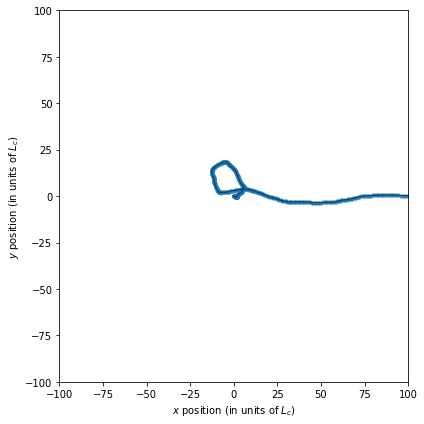

In [21]:
stepi, stepD, stride = 0, 1000, 1
stepf = stepi + stepD

plt.clf()
lims = 1.0e2*np.vstack((-np.ones(3), np.ones(3))).T
fig, ax = le_sim.quick_plot(start=stepi, stop=stepf, step=stride, lims=lims, figscale=2, aspect=0.75)

In [81]:
strj = pd.HDFStore('data/ELI_newtest.aux.h5', 'r')

In [82]:
strj2 = pd.HDFStore('data/LI_newtest.aux.h5', 'r')

In [29]:
pd.concat([le_sim.positions, gle_sim.positions], axis=1)

x1          y1          z1           x1          y1  \
1.0          0.00000     0.00000     0.00000      0.00000     0.00000   
2.0         -0.00603    -0.02776    -0.01894     -0.00603    -0.02776   
3.0         -0.00697    -0.04397    -0.05981     -0.00697    -0.04397   
4.0          0.02826    -0.03424    -0.07965      0.02826    -0.03424   
5.0          0.07314    -0.05270    -0.04920      0.07314    -0.05270   
6.0          0.08962    -0.09811     0.02052      0.08961    -0.09810   
7.0          0.13534    -0.12631     0.13088      0.13533    -0.12630   
8.0          0.20825    -0.11913     0.27596      0.20824    -0.11912   
9.0          0.26284    -0.09663     0.43832      0.26283    -0.09661   
10.0         0.31373    -0.10420     0.60185      0.31371    -0.10419   
11.0         0.38412    -0.14293     0.74316      0.38409    -0.14291   
12.0         0.49552    -0.18246     0.79593      0.49547    -0.18244   
13.0         0.62840    -0.26587     0.75868      0.62834    -0.26584   
14.0         0.77746    -0.33867     0.72990      0.77738    -0.33864   
15.0         0.94766    -0.39382     0.72728      0.94756    -0.39377   
...              ...         ...         ...          ...         ...   
9986.0   15280.73989 -5222.68487 -3285.84001  14016.51335 -4926.29435   
9987.0   15285.44302 -5223.20832 -3288.49171  14020.99243 -4926.72428   
9988.0   15290.18208 -5223.79473 -3291.10789  14025.50735 -4927.21716   
9989.0   15294.91157 -5224.39599 -3293.71911  14030.01260 -4927.72489   
9990.0   15299.59774 -5224.96974 -3296.34277  14034.47444 -4928.20510   
9991.0   15304.26895 -5225.53168 -3298.95552  14038.92124 -4928.67351   
9992.0   15308.95484 -5226.14656 -3301.58525  14043.38263 -4929.19485   
9993.0   15313.66448 -5226.78035 -3304.22298  14047.86767 -4929.73509   
9994.0   15318.38807 -5227.39729 -3306.81169  14052.36659 -4930.25849   
9995.0   15323.13506 -5227.99036 -3309.35743  14056.88881 -4930.75800   
9996.0   15327.92767 -5228.58848 -3311.89730  14061.45655 -4931.26258   
9997.0   15332.77753 -5229.20938 -3314.46662  14066.08146 -4931.78992   
9998.0   15337.64291 -5229.79618 -3317.03286  14070.72178 -4932.28316   
9999.0   15342.51391 -5230.36803 -3319.58823  14075.36765 -4932.76144   
10000.0  15347.39192 -5230.95188 -3322.14078  14080.02042 -4933.25173   

                 z1  
1.0         0.00000  
2.0        -0.01894  
3.0        -0.05981  
4.0        -0.07964  
5.0        -0.04919  
6.0         0.02053  
7.0         0.13089  
8.0         0.27596  
9.0         0.43831  
10.0        0.60182  
11.0        0.74312  
12.0        0.79587  
13.0        0.75860  
14.0        0.72981  
15.0        0.72716  
...             ...  
9986.0  -2927.82205  
9987.0  -2930.43633  
9988.0  -2933.01502  
9989.0  -2935.58869  
9990.0  -2938.17474  
9991.0  -2940.74981  
9992.0  -2943.34181  
9993.0  -2945.94175  
9994.0  -2948.49259  
9995.0  -2951.00043  
9996.0  -2953.50232  
9997.0  -2956.03361  
9998.0  -2958.56176  
9999.0  -2961.07898  
10000.0 -2963.59332  

[10000 rows x 6 columns]

# Langevin Impulse-based integrator

The Langevin Impulse (LI) integrator is the "SD" (stochastic dynamics) integrator used in GROMACS (and also GROMOS). It is an "impulsive Langevin" extension to the familiar leap-frog algorithm. Though the authors state at the outset that they seek an algorithm that is of the same order of accuracy as the Verlet-type algorithms, though it's not clear whether this stochastic algorithm is truly correct to second order in the timestep, $\mathcal{O}(\Delta t^2)$.

Primary reference: [N. Goga, et al. (2012), JCTC](https://pubs-acs-org.ezproxy1.lib.asu.edu/doi/10.1021/ct3000876)

See also: [R. D. Skeel & J. A. Izaguirre (2002), Mol. Phys.](http://www.tandfonline.com.ezproxy1.lib.asu.edu/doi/abs/10.1080/0026897021000018321)

---

## Assumed dynamical form

The generalized Langevin dynamics (GLD) equation of motion is represented in the extended/auxiliary variable formalism by the following set of coupled, first-order SDEs:

$$
\dot{x} = v(t)
$$

$$
\dot{v} = \frac{1}{m}F(x(t)) - \frac{1}{m}\sum_{k=1}^N \sigma_k(t) - \frac{c_0}{m}\:\! v(t) + \hat{\xi}_0(t),
$$

$$
\dot{\sigma}_k = -\frac{1}{\tau_k}\sigma_k(t) - \frac{c_k}{\tau_k}v(t) + \frac{1}{\tau_k}\hat{\xi}_k(t)
$$

where $x$, $v$, and $m$ are, respectively, the main particle's position, velocity and mass, $c_0 = \sum c_k$ with $\gamma_0 = c_0/m = 1/\tau_0$ being the collision frequency for the main particle, $\gamma_k = c_k/m = 1/\tau_k$ is the collision frequency for auxiliary particle $k$, and $\hat{\xi}_0$ and $\hat{\xi}_k$ are thermal noise terms for the main and $k^\text{th}$ particle, respectively. There are $N$ auxiliary particles, each subject to an independent noise process, $\xi_k$; $\hat{\xi}_0$ and $\hat{\xi}_k$ describe $N+1$ zero-mean, white Gaussian noise processes with autocorrelations given by

$$
\left\langle\xi_0(t)\xi_0(t')\right\rangle = \sum_{k=1}^N \frac{2k_BT c_k}{m}\delta(t-t').
$$

$$
\left\langle\xi_k(t)\xi_k(t')\right\rangle = \frac{2k_BT c_k}{\tau_k^2}\delta(t-t').
$$

Since $\xi_0$ is calculated from a weighted sum of the $\xi_k$, the $N$ auxiliary noise processes, there are $N$ independent stochastic samples required per timestep.

---

## Numerical discretization


### Langevin Impulse approach

An LI-like numerical algorithm can be written in five steps<sup>[1](#footnote1)</sup>:

$$
v_\text{LF}^{n+1/2} = v^{n-1/2} + \frac{\Delta t}{m}\left[F(x^n) - \sum_{k=1}^N \sigma_k^n\right]
$$

$$
\Delta v = -(1-\theta_0)\:\! v_\text{LF}^{n+1/2} + \sqrt{(1-\theta_0^2)\:\!\frac{k_BT}{m}} \,\mathcal{W}_0^n
$$

$$
x^{n+1} = x^n + \Delta t\left(v_\text{LF}^{n+1/2} + \frac{1}{2}\Delta v\right)
$$

$$
s_k^{n+1} = \theta_k s_k^n - (1-\theta_k)\:\!c_k v_\text{LF}^{n+1/2} + \sqrt{\frac{(1-\theta_k^2)}{\tau_k}c_k k_BT} \,\mathcal{W}_k^n
$$

$$
v^{n+1/2} = v_\text{LF}^{n+1/2} + \Delta v
$$

where

$$
\theta_0 = e^{-c_0 \Delta t/m} = e^{-\Delta t/\tau_0} = e^{-\gamma_0 \Delta t} \qquad \text{and} \qquad \theta_k = e^{-\Delta t/\tau_k}.
$$

Note that $\mathcal{W}_k^n$ is a zero-mean, unit variance white noise process sampled independently of the other noises at each timestep, $n$, while $\mathcal{W}_0^n$ is a weighted sum of the $N$ independent white noises. Also note that $v_\text{LF}$ is the usual MD velocity update for the leap-frog scheme, which now includes the "auxiliary forces", $\sigma_k$. The _effective collision frequency_<sup>[2](#footnote2)</sup> of particle $k$ is given by $1/\tau_k$, and $0 \leq (1 -\theta_k) \leq 1$ is a _velocity reduction factor_ that scales the impulsive application of friction and noise.

**Notes**:

<a name="footnote1">1</a>: For some reason, the [GROMACS manual](http://manual.gromacs.org/documentation/2018/manual-2018.pdf) specifies the noise term with $\sqrt{(1-\alpha^2)k_BT/m}$ rather than $\sqrt{\alpha(2-\alpha)k_BT/m}$ as specified in [N. Goga, et al. (2012), JCTC](https://pubs-acs-org.ezproxy1.lib.asu.edu/doi/10.1021/ct3000876). The GROMACS definition makes somewhat _less_ sense to me when considering the series expansion in powers of small $\gamma\Delta t$, though I'm not sure whether there's simply a typo in the manual or they're using a different definition. For the latter expression ($\sqrt{\alpha(2-\alpha)k_BT/m}$, where $\alpha = 1 - \exp(-\gamma_0\Delta t)$), it can be easily seen that $(1-\theta_0) = \alpha$ and $(1-\theta_0^2) = \alpha(2-\alpha)$

<a name="footnote2">2</a>: From what I currently understand, $\gamma_0 = 1/\tau_0$ is the collision frequency that results from discretizing the noise and friction in the system using $(1-\theta_0)$. It makes sense, however, that when $\Delta t/\tau_0 \ll 1$, we have $(1-\theta_0) = \Delta t/\tau_0 + \mathcal{O}(\Delta t^2)$ and $(1-\theta_0^2) = 2\Delta t/\tau_0$, which leads to

$$
\Delta v = -\frac{\Delta t}{\tau_0}\:\! v_\text{LF}^{n+1/2} + \sqrt{\frac{2 k_BT\Delta t}{\tau_0 m}} \,\mathcal{W}_0^n
$$

---

---

# Grønbech-Jensen–Farago integrator

This integrator is described by the authors as "a revision to the well known Störmer–Verlet algorithm for simulating second order differential equations. The revision addresses the inclusion of linear friction with associated stochastic noise, and we analytically demonstrate that the new algorithm correctly reproduces diffusive behavior of a particle in a flat potential." The algorithm is correct to second order in the timeste, $\mathcal{O}(\Delta t^2)$.

Reference: [N. Grønbech-Jensen  & O. Farago (2013). Mol.Phys.](http://www.tandfonline.com.ezproxy1.lib.asu.edu/doi/abs/10.1080/00268976.2012.760055)

---

## Assumed dynamical form

The equation of motion is a second-order SDE of the Langevin type:

$$
\dot{x} = v(t)
$$

$$
m\dot{v} = F(x(t)) - m\:\!\gamma\:\! v(t) + \beta(t),
$$

where $m$ is the particle mass, $\gamma = \zeta/m$ is the collision frequency, $\zeta$ is the usual friction coefficient, and the noise autocorrelation is given by

$$
\left\langle\beta(t)\beta(t')\right\rangle = 2m\:\!\gamma \:\!k_BT\:\!\delta(t-t').
$$

## Numerical discretization

First, we note that the autocorrelation is expressed in terms of the time step (just like in the first-order BBK algorithm),

$$
\left\langle\beta^n\beta^m\right\rangle = 2m\:\!\gamma \:\!k_BT\Delta t\:\!\delta_{nm},
$$

which will be used in the expressions that follow. The numerical algorithm is given by

$$
x^{n+1} = x^n + \alpha\Delta t\:\! v^n + \frac{ \alpha\Delta t^2}{2m}F(x^n) + \frac{\alpha\Delta t}{2m}\beta^{n+1}
$$

$$
v^{n+1} = v^n + \frac{\Delta t}{2m}\left[F\left(x^n\right) + F\left(x^{n+1}\right)\right] - \gamma\left(x^{n+1} - x^n\right) + \frac{1}{m}\beta^{n+1}
$$

where

$$
\alpha = \frac{1}{1 + \frac{\gamma\Delta t}{2}},
$$

where the timestep must be sufficiently small to satisfy $\gamma\Delta t < 2$. Using the substitution $F(x^n) = F^n$ along with $\beta^n = \sqrt{2m\:\!\gamma \:\!k_BT\Delta t}\:\! \mathcal{W}^n$, where $\mathcal{W}$ is a zero-mean, unit-variance white noise, we can rewrite the above discretization as

$$
\Delta x = \alpha\Delta t\left(v^n + \frac{\Delta t}{2m}F^n + \frac{1}{2}\sqrt{\frac{2\gamma\:\!k_BT \Delta t}{m}}\,\mathcal{W}^{n+1}\right)
$$

$$
x^{n+1} = x^n + \Delta x
$$

$$
v^{n+1} = v^n - \gamma\Delta x + \frac{\Delta t}{2m}\left(F^n + F^{n+1}\right) + \sqrt{\frac{2\gamma\:\!k_BT\Delta t}{m}}\,\mathcal{W}^{n+1}
$$

---